In [1]:
from jax import config
config.update('jax_enable_x64', True)

from flax import nnx
import jax
import optax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

import gpjax as gpx
from gpjax import Dataset
from gpjax.gps import Prior as GPPrior
from gpjax.kernels.approximations import RFF
from gpjax.kernels import RBF
from gpjax.parameters import transform, DEFAULT_BIJECTION

from uncprop.utils.gpjax_models import construct_gp, construct_batch_gp, train_gp_hyperpars
from uncprop.core.surrogate import GPJaxSurrogate
from uncprop.utils.gpjax_multioutput import (
    BatchIndependentGP,
    get_batch_gp_from_template,
    fit_batch_independent_gp,
    _make_batched_loss_and_grad,
    _get_single_output_dataset,
)

/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# latent functions
f1 = lambda x: jnp.sin(x) + 0.3 * jnp.cos(10*x)
f2 = lambda x: -0.5 * x**2

# design data
x = jnp.linspace(0, 10, 5).reshape(-1, 1)
xgrid = jnp.linspace(0, 10, 100).reshape(-1, 1)

y = jnp.hstack([f1(x), f2(x)])
ygrid = jnp.hstack([f1(xgrid), f2(xgrid)])

design = Dataset(x, y)
testdata = Dataset(xgrid, ygrid)

## Helper functions for testing

In [3]:
# Baseline for testing: computing loss/gradient one at a time (not vectorized)

def _print_tree_vals(param):
    l = param.prior.kernel.lengthscale.get_value()
    v = param.prior.kernel.variance.get_value()
    sd = param.likelihood.obs_stddev.get_value()
    m = param.prior.mean_function.constant.get_value()

    print(l, v, sd, m)


def single_losses_grads(i, batchgp, objective, bijection):
    D = _get_single_output_dataset(design, i)
    g, p, s = nnx.split(batchgp.posterior_list[i], gpx.parameters.Parameter, ...)
    phi = transform(p, bijection, inverse=True)

    def l(phi):
        params = transform(phi, bijection)
        model = nnx.merge(g, params, s)
        return objective(model, D)

    loss = l(phi)
    gradient = jax.grad(l)(phi)

    print(f'loss: {loss}')
    print('gradient:')
    _print_tree_vals(gradient)


def vectorized_losses_grads(loss_and_grad_vect, batchgp, bijection):
    phi = transform(batchgp.params, bijection, inverse=True)
    loss, gradient = loss_and_grad_vect(phi)

    print(f'loss: {loss}')
    print('gradient:')
    _print_tree_vals(gradient)


def plot_gps(design, testdata, gp: GPJaxSurrogate, pred=None):
    fig, axs = plt.subplots(1, gp.output_dim)
    if gp.output_dim > 1:
        axs = axs.ravel()
    else:
        axs = [axs]

    xgrid = testdata.X.ravel()
    if pred is None:
        pred = gp(testdata.X)
    
    for i, ax in enumerate(axs):
        m = jnp.atleast_2d(pred.mean)[i]
        sd = jnp.atleast_2d(pred.stdev)[i]

        ax.fill_between(xgrid, m-2*sd, m+2*sd, alpha=0.4, color='lightblue')
        ax.plot(xgrid, testdata.y[:,i], color='black', label='true')    
        ax.plot(xgrid, m, color='blue', label='mean')
        ax.plot(design.X.ravel(), design.y[:,i], 'ro')
        ax.legend()

    fig.tight_layout()
    return fig, axs

### Constructing batch GP from single-outpit template

In [4]:
def gp_factory(dataset):
    return construct_gp(dataset, set_bounds=False)[0]

batchgp = get_batch_gp_from_template(gp_factory, design)

# Optimizing Hyperparameters

In [6]:
# optimizer and objective function
opt = optax.adam(1e-1)
objective = lambda p, d: -gpx.objectives.conjugate_mll(p, d)

### Testing that batched loss function is correctly defined

In [7]:
# vectorized computations
bijection = DEFAULT_BIJECTION
loss_and_grad_vect = _make_batched_loss_and_grad(batchgp, objective, bijection, design)

print('GP 1:')
single_losses_grads(0, batchgp, objective, bijection)

print('\nGP 2:')
single_losses_grads(1, batchgp, objective, bijection)

print('\nVectorized:')
vectorized_losses_grads(loss_and_grad_vect, batchgp, bijection)

GP 1:
loss: 2084.5677156610914
gradient:
[3081.89094655] -1641.3601269753967 -7.698937248460797e-06 47.6538068659691

GP 2:
loss: 19.407487716687505
gradient:
[0.89806426] -0.008906382813585856 -5.088002350510418e-12 0.08703846890916944

Vectorized:
loss: [2084.56771566   19.40748772]
gradient:
[[3.08189095e+03]
 [8.98064259e-01]] [-1.64136013e+03 -8.90638281e-03] [-7.69893725e-06 -5.08800235e-12] [47.65380687  0.08703847]


### Run vectorized optimization

In [ ]:
phi = transform(batchgp.params, DEFAULT_BIJECTION, inverse=True)
print(f'Starting loss: {loss_and_grad_vect(phi)[0]}')

batchgp, history = fit_batch_independent_gp(
    batch_gp=batchgp,
    objective=objective,
    optim=opt,
    num_iters=1000
)

phi_final = transform(batchgp.params, DEFAULT_BIJECTION, inverse=True)
print(f'Final loss: {loss_and_grad_vect(phi_final)[0]}')

Starting loss: [2084.56771566   19.40748772]


NameError: name 'new_batchgp' is not defined

# Prediction

Once the hyperparameters of a BatchIndependentGP object are optimized and fixed, we cannot use this
directly for vectorized prediction since gpjax kernels do not natively support batching over
hyperparamters. We thus convert to a GP conjugate posterior object with a custom kernel that handles
the batching.

In [14]:
from uncprop.utils.gpjax_multioutput import BatchedRBF

def convert_gp_to_batch_kernel(gp: gpx.gps.ConjugatePosterior, design: Dataset):
    batch_dim = design.y.shape[1]
    kernel = gp.prior.kernel
    meanf = gp.prior.mean_function
    likelihood = gp.likelihood

    batched_kernel = BatchedRBF(batch_dim=batch_dim,
                                input_dim=design.in_dim,
                                lengthscale=kernel.lengthscale, 
                                variance=kernel.variance)

    batched_prior = gpx.gps.Prior(mean_function=meanf, kernel=batched_kernel)
    batched_posterior = batched_prior * likelihood
    surrogate = GPJaxSurrogate(batched_posterior, design)

    return surrogate


In [ ]:
surrogate = convert_gp_to_batch_kernel(batchgp.batch_posterior, design)

### Validating batch predictions 

(<Figure size 640x480 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

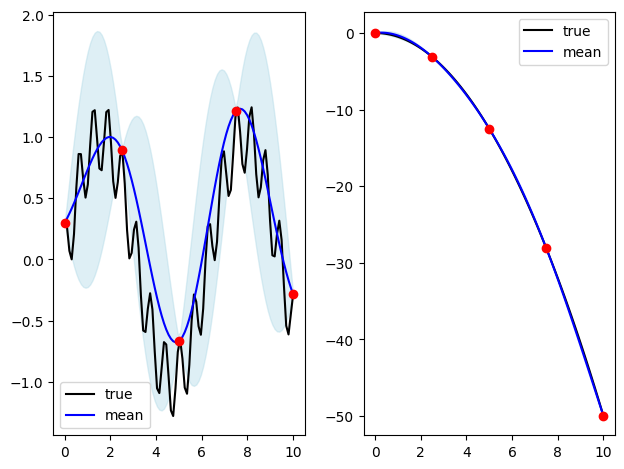

In [11]:
plot_gps(design, testdata, surrogate)

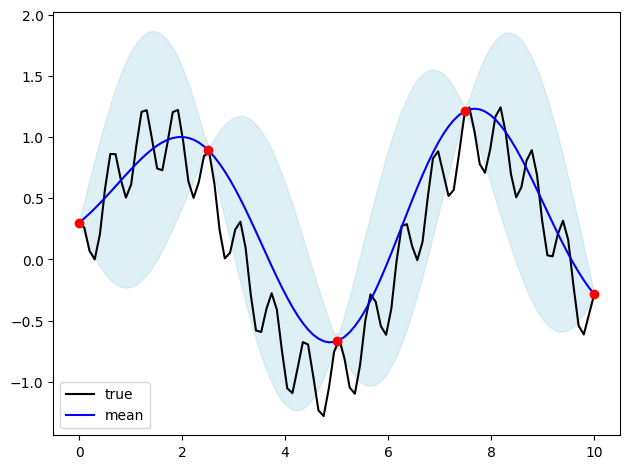

In [15]:
# At present, to wrap a gpjax posterior that does not have a batched kernel, one 
# must first convert to a batch GP with batch size 1. 

# output index
idx = 0

# convert gpjax GP to batch with batch size 1
gp_single = batchgp.posterior_list[idx]
design_single = _get_single_output_dataset(design, idx)
surrogate_single = convert_gp_to_batch_kernel(gp_single, design_single)

# predictions
testdata_single = _get_single_output_dataset(testdata, idx)
fig, ax = plot_gps(design_single, testdata_single, surrogate_single)


In [16]:
# conditioning methods currently only work for batch size one
xnew = jnp.array([[6.0]])
ynew = f1(xnew)
newdata = Dataset(xnew, ynew)
conditional_pred = surrogate_single.condition_then_predict(testdata_single.X, given=(xnew, ynew))

plot_gps(design_single + newdata, testdata_single, surrogate_single, pred=conditional_pred)


TypeError: dot_general requires contracting dimensions to have the same shape, got (1,) and (5,).

In [24]:
a = jnp.ones((2, 3, 3))
b = jnp.ones((2, 1, 3))

jnp.concatenate([a, b], axis=1).shape

(2, 4, 3)

In [ ]:
    def _update_conditioning_cache(self, given: tuple[ArrayLike, Dataset]):
        """ 
        Updates the inverse kernel matrix P = (K + sig2*I)^{-1} and the set
        of design points when a batch of new conditioning points is added.
        
        Args:
            tuple, containing:
                Xnew: (m, d) set of new conditioning inputs
                ynew: (m, q) response values at the conditioning inputs

        Returns:
            tuple, containing:
                Pnew: (q, n+m, n+m), the updated batched inverse kernel matrix
                dataset_new: the updated set of training data
        """
        Xnew = given[0].reshape(-1, self.input_dim)
        ynew = given[1].reshape(-1, self.output_dim)
        new_dataset = self.design + Dataset(X=Xnew, y=ynew)
        
        # Partitioned matrix inverse updates.
        num_new_points = Xnew.shape[0]
        P = self.P.squeeze(0) # (q, n, n)
        Xcurr = self.design.X.copy()

        def _step(carry, xnew):
            P_curr, X_curr = carry
            P_new = self._update_single_point_kernel_precision(P_curr, X_curr, xnew)
            X_new = jnp.vstack([X_curr, xnew])
            return (P_new, X_new), None

        (P_final, X_final), _ = jax.lax.scan(_step, )

        for i in range(num_new_points):
            xnew = Xnew[i]
            Sigma_inv = self._update_single_point_kernel_precision(Sigma_inv, Xcurr, xnew)
            Xcurr = jnp.vstack([Xcurr, xnew])

        # bring back batch dimension
        return Sigma_inv[None, ...], new_dataset

### Validating batch vs single output predictions

In [ ]:
def test_batch_gp(surrogate, batchgp, train_data, test_inputs):
    test_batch_gp_hyperpars(surrogate, batchgp)
    test_batch_gp_meanf(surrogate, batchgp, test_inputs)
    test_batch_gp_gram(surrogate, batchgp, test_inputs)
    test_batch_gp_cross_cov(surrogate, batchgp, test_inputs)
    # test_batch_gp_pred(surrogate, batchgp, train_data, test_inputs)

def test_batch_gp_hyperpars(surrogate, batchgp):
    posts = batchgp.posterior_list

    # hyperparameters
    l_surr = surrogate.gp.prior.kernel.lengthscale.get_value()
    l_posts = jnp.array([post.prior.kernel.lengthscale.get_value() for post in posts])

    v_surr = surrogate.gp.prior.kernel.variance
    v_posts = jnp.array([post.prior.kernel.variance.get_value() for post in posts])

    obs_sd_surr = surrogate.gp.likelihood.obs_stddev.get_value()
    obs_sd_posts = jnp.array([post.likelihood.obs_stddev.get_value() for post in posts])

    m_surr = surrogate.gp.prior.mean_function.constant.get_value()
    m_posts = jnp.array([post.prior.mean_function.constant.get_value() for post in posts])

    print('lengthscales equal:', jnp.array_equal(l_surr, l_posts))
    print('variances equal:', jnp.array_equal(v_surr, v_posts))
    print('obs stdevs equal:', jnp.array_equal(obs_sd_surr, obs_sd_posts))
    print('obs stdevs equal:', jnp.array_equal(m_surr, m_posts))


def test_batch_gp_meanf(surrogate, batchgp, test_inputs):
    post_list = batchgp.posterior_list
    mean_surr = surrogate.gp.prior.mean_function(test_inputs)
    mean_posts = jnp.hstack([post.prior.mean_function(test_inputs) for post in post_list])
    print(f'prior means equal: {jnp.array_equal(mean_surr, mean_posts)}')

def test_batch_gp_gram(surrogate, batchgp, test_inputs):
    post_list = batchgp.posterior_list
    gram_surr = surrogate.prior_gram(test_inputs)
    gram_posts = jnp.stack([post.prior.kernel.gram(test_inputs).to_dense() for post in post_list])
    print(f'prior grams equal: {jnp.array_equal(gram_surr, gram_posts)}')

def test_batch_gp_cross_cov(surrogate, batchgp, test_inputs):
    post_list = batchgp.posterior_list
    cross_surr = surrogate.prior_cross_covariance(test_inputs, test_inputs)
    cross_posts = jnp.stack([post.prior.kernel.cross_covariance(test_inputs, test_inputs) for post in post_list])
    print(f'prior cross covs equal: {jnp.array_equal(cross_surr, cross_posts)}')

def test_batch_gp_pred(surrogate, batchgp, train_data, test_inputs):
    post_list = batchgp.posterior_list
    pred_surr = surrogate(test_inputs)
    surr_mean = pred_surr.mean
    surr_var = pred_surr.variance

    for i in range(batchgp.dim_out):
        pred_post_latent = post_list[i](test_inputs, train_data)
        pred_post = post_list[i].likelihood(pred_post_latent)

        print(f'output {i+1} predictions:')
        print(f'\tpred means equal: {jnp.array_equal(surr_mean[i], pred_post.mean)}')
        print(f'\tpred variances equal: {jnp.array_equal(surr_var[i], pred_post.variance)}')

In [ ]:
from uncprop.utils.gpjax_multioutput import BatchIndependentGP, BatchedRBF
from uncprop.utils.gpjax_models import _get_distance_stats_from_design
import gpjax as gpx
import optax

def construct_batch_gp(design):
    Y = design.y
    batch_dim = Y.shape[1]
    constants_init = gpx.parameters.Real(value=Y.mean(axis=0))
    meanf = gpx.mean_functions.Constant(constants_init)

    # prior (batch) kernel
    dist_stats = _get_distance_stats_from_design(design)
    lengthscale_init = dist_stats['mean']
    vars_init = Y.var(axis=0)

    kernel = BatchedRBF(batch_dim=batch_dim,
                        input_dim=design.in_dim,
                        lengthscale=lengthscale_init, 
                        variance=vars_init)

    gp_prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

    obs_sd_init = jnp.tile(gp_prior.jitter, (batch_dim, 1))
    gp_likelihood = gpx.likelihoods.Gaussian(num_datapoints=design.n, 
                                             obs_stddev=obs_sd_init)
    gp_posterior = gp_prior * gp_likelihood

    return gp_posterior


# fit and train
gp_posterior = construct_batch_gp(design)
batchgp = BatchIndependentGP(dataset=design, batch_posterior=gp_posterior)
# batchgp = get_batch_gp_from_template(gp_factory, design)

objective = lambda p, d: -gpx.objectives.conjugate_mll(p, d)
opt = optax.adam(1e-1)

batchgp, history = fit_batch_independent_gp(
    batch_gp=batchgp,
    objective=objective,
    optim=opt,
    num_iters=1000
)
# surrogate = GPJaxSurrogate(gp=batchgp.batch_posterior,
#                            design=design)

 # run tests
# test_batch_gp(surrogate, batchgp, surrogate.design, testdata.X)

In [ ]:
jnp.array([1,2,3]).reshape(3, -1)

In [ ]:
import jax

graphdef, params, *static = nnx.split(gp_posterior, gpx.parameters.Parameter, ...)
params_promoted = jax.tree.map(lambda p: jnp.broadcast_to(p, ), params)



flat = jax.tree.map(lambda p: p, params)
shp = jax.tree.map(lambda p: print(p.shape), params)

# jax.tree.leaves(shp)

jax.tree.leaves(flat)

In [ ]:
idx = 1

single_design = Dataset(surrogate.design.X, surrogate.design.y[:,[idx]])
pred = surrogate(testdata.X)
pred_baseline_latent = batchgp.posterior_list[idx](testdata.X, single_design)
pred_baseline = batchgp.posterior_list[idx].likelihood(pred_baseline_latent)

fig, axs = plt.subplots(1, 2)
axs = axs.ravel()
ax = axs[0]
ax.scatter(pred_baseline.mean, pred.mean[idx])
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
grid = jnp.linspace(xmin, xmax, 100)
ax.plot(grid, grid, color='gray', linewidth=1, linestyle='--', label='y = x')
ax.set_title('mean')

ax = axs[1]
ax.scatter(pred_baseline.variance, pred.variance[idx])
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
grid = jnp.linspace(xmin, xmax, 100)
ax.plot(grid, grid, color='gray', linewidth=1, linestyle='--', label='y = x')
ax.set_title('variance')

fig.show()

In [ ]:
U = testdata.X[:2]

idx = 1
gram_surr = surrogate.prior_gram(U)
gram2 = surrogate.gp.prior.kernel.gram(U).to_dense()
gram_baseline = batchgp.posterior_list[idx].prior.kernel.gram(U).to_dense()

In [ ]:
print(gram_surr[idx]) # equal
print(gram2[..., idx]) # equal
print(gram_baseline)

In [ ]:
a = batchgp.posterior_list[0].prior.mean_function(U)
b = batchgp.posterior_list[1].prior.mean_function(U)

jnp.hstack([a, b])

In [ ]:
def __call__(self, x: Float[Array, " D"], y: Float[Array, " D"]) -> ScalarFloat:
    x = self.slice_input(x) / self.lengthscale.value 
    y = self.slice_input(y) / self.lengthscale.value
    K = self.variance.value * jnp.exp(-0.5 * squared_distance(x, y))
    return K.squeeze()

In [ ]:
u = U[0]
v = U[1]

kernel = surrogate.gp.prior.kernel

kernel(u, v)

In [ ]:
batchgp.posterior_list[1].prior.kernel(u, v)

# NEW

In [ ]:
from gpjax.kernels.stationary import RBF

from uncprop.utils.gpjax_multioutput import (
    BatchDenseKernelComputation,
    BatchedStationaryKernel,
    BatchedRBF,
)

In [ ]:
def setup_case_one(key):
    d, q = 1, 3
    x = jnp.array([1, 2, 3])
    y = jnp.array([4, 5])
    z = jnp.array(6)

    lengthscales = jnp.array([1, 2, 3])[:, None]
    variances = jnp.array([1, 2, 3])

    return d, q, x, y, z, lengthscales, variances

def setup_case_two(key):
    d, q = 2, 2
    kx, ky, kz = jr.split(key, 3)

    x = jr.uniform(kx, (3, 2))
    y = jr.uniform(ky, (2, 2))
    z = jr.uniform(kz, (2,))

    lengthscales = jnp.array([[0.5, 0.1], [0.4, 0.3]]) # (q, d)
    variances = 1.0

    return d, q, x, y, z, lengthscales, variances

def kernel_list_to_batch(kers, x, y):
    return jnp.stack([ker.cross_covariance(x, y) for ker in kers])

def test_kernel(key, test_fn):
    d, q, x, y, z, l, v = test_fn(key)
    kernel = BatchedRBF(batch_dim=q, input_dim=d, lengthscale=l, variance=v)

    x = x.reshape(-1, d)
    y = y.reshape(-1, d)
    z = z.reshape(-1, d)

    l = kernel.lengthscale
    v = kernel.variance

    kers = [RBF(lengthscale=l[i], variance=v[i], n_dims=d) for i in range(q)]

    def k0(x, y):
        return kernel_list_to_batch(kers, x, y)

    def k1(x, y):
        return kernel.cross_covariance(x, y)

    assert jnp.array_equal(k0(x, y), k1(x, y))
    assert jnp.array_equal(k0(x, z), k1(x, z))
    assert jnp.array_equal(k0(y, z), k1(y, z))

In [ ]:
# test batched kernel
d, q, x, y, z, lengthscales, variances = setup_case_one(_)

kernel = BatchedRBF(batch_dim=q,
                    input_dim=d,
                    lengthscale=lengthscales, 
                    variance=variances)

In [ ]:
key = jr.key(325234)
test_keys = jr.split(key, 2)

test_kernel(test_keys[0], setup_case_one)
test_kernel(test_keys[1], setup_case_two)